# Phast - Dispersion Side View vs Crosswind Distance
Dispersing clouds often want to be visualised in 3D. One way to do this is to produce a side view plot (XZ plane) at various crosswind distances (Y). This example shows how this can be done.

## Import the required items

In [1]:
import {
  VesselStateCalculation,
  VesselLineRuptureCalculation
} from "./src/calculations/discharge";

import { DispersionCalculation } from "./src/calculations/dispersion";

import { SideviewAtTimeCalculation } from "./src/calculations/dispersionView";

import {
  State,
  Material,
  MaterialComponent,
  Vessel,
  LineRupture,
  DischargeParameters,
  DispersionParameters,
  Weather,
  Substrate,
  Bund,
  DispersionOutputConfig,
  LocalPosition,
} from "./src/entities";

import {
  ResultCode,
  FluidSpec,
  MixtureModelling,
  VesselShape,
  SurfaceType,
  AtmosphericStabilityClass,
  Resolution
} from "./src/enums";

import { setAccessToken } from "./src/utilities";
import { getMaterialByName } from "./src/materials";
import Plotly from "tslab-plotly";
import * as tslab from "tslab";

// Set up access token
const accessToken = process.env.PWS_ACCESS_TOKEN;
if (!accessToken) {
  throw new Error("PWS_ACCESS_TOKEN environment variable is not set.");
}
setAccessToken(accessToken);


## Running discharge calculations

### Calculate the vessel conditions
Define the input data and determine the vessel conditions...

In [2]:
const stateTemperature = 290.0;
const statePressure = 7.0e6;
const stateLiquidFraction = 1.0;
const surfaceType = SurfaceType.LAND;
const surfaceRoughness = 0.183;
const windSpeed = 1.5;
const stabilityClass = AtmosphericStabilityClass.STABILITY_D;
const endPointConcentration = 0.0;
const specifyBund = true;
const bundHeight = 0.5;
const bundDiameter = 5.0;

// Define the initial state of the vessel.
const state = new State({
  temperature: stateTemperature,
  pressure: statePressure,
  liquidFraction: stateLiquidFraction,
  flashFlag: FluidSpec.TP,
  mixtureModelling: MixtureModelling.PC
});

// Define the material contained by the vessel.
const material = await getMaterialByName("AMMONIA");

// Create a vessel state calculation using the material and state.
const vesselStateCalculation = new VesselStateCalculation(material, state);

// Run the vessel state calculation.
console.log('Running vessel_state_calculation...');
const resultCode = await vesselStateCalculation.run();

// Print any messages.
if (vesselStateCalculation.messages && vesselStateCalculation.messages.length > 0) {
    console.log('Messages:');
    for (const message of vesselStateCalculation.messages) {
        console.log(message);
    }
}

if (resultCode === ResultCode.SUCCESS) {
    console.log("Vessel state calculation successful.");
    console.log("The vessel conditions are " + vesselStateCalculation.vesselConditions);

    var vesselConditions = vesselStateCalculation.vesselConditions;
} else {
    console.log("Vessel state calculation failed.");
}

Running vessel_state_calculation...
Vessel state calculation successful.
The vessel conditions are 4


### Calculate the discharge
Use the VesselLineRuptureCalculation class to model the discharge, which requires a Vessel, LineRupture and DischargeParameters...

In [3]:
const vessel = new Vessel({
  state: state,
  material: material,
  vesselConditions: vesselStateCalculation.vesselConditions,
  liquidFillFractionByVolume: 0.7,
  shape: VesselShape.VESSEL_CUBOID,
  height: 2,
  width: 1,
  length: 3
});

const lineRupture = new LineRupture({
  pipeDiameter: 0.1,
  pipeLength: 1.0,
  pipeHeightFraction: 0.1
});

const vesselLineRuptureCalculation = new VesselLineRuptureCalculation(
  vessel,
  lineRupture,
  new DischargeParameters()
);

console.log('Running vessel_line_rupture_calculation...');
const resultCode2 = await vesselLineRuptureCalculation.run();

// Print any messages.
if (vesselLineRuptureCalculation.messages && vesselLineRuptureCalculation.messages.length > 0) {
    console.log('Messages:');
    for (const message of vesselLineRuptureCalculation.messages) {
        console.log(message);
    }
}

if (resultCode2 === ResultCode.SUCCESS) {
    console.log(`SUCCESS: vessel_line_rupture_calculation (${vesselLineRuptureCalculation.calculationElapsedTime}ms)`);
} else {
    console.log(`FAILED vessel_line_rupture_calculation with result code ${resultCode2}`);
}

Running vessel_line_rupture_calculation...
Messages:
DISC 2006: Flow rate capped to that predicted by the orifice model, 62368.9 [kg/m2.s]
SUCCESS: vessel_line_rupture_calculation (514ms)


## Running dispersion calculations

### Calculate the dispersion
We can pass the discharge results into a DispersionCalculation along with other required inputs...

In [4]:
const bund = new Bund({
  specifyBund: specifyBund,
  bundHeight: bundHeight,
  bundDiameter: bundDiameter
});

const substrate = new Substrate({
  bund: bund,
  surfaceType: surfaceType,
  surfaceRoughness: surfaceRoughness
});

const weather = new Weather({
  windSpeed: windSpeed,
  stabilityClass: stabilityClass
});

const dispersionParameters = new DispersionParameters();

const dispersionCalculation = new DispersionCalculation(
  vesselLineRuptureCalculation.exitMaterial!,
  substrate,
  vesselLineRuptureCalculation.dischargeResult!,
  vesselLineRuptureCalculation.dischargeRecords!,
  vesselLineRuptureCalculation.dischargeRecords!.length,
  weather,
  dispersionParameters,
  endPointConcentration
);

console.log('Running dispersion_calculation...');
const resultCode3 = await dispersionCalculation.run();

// Print any messages.
if (dispersionCalculation.messages && dispersionCalculation.messages.length > 0) {
    console.log('Messages:');
    for (const message of dispersionCalculation.messages) {
        console.log(message);
    }
}

if (resultCode3 === ResultCode.SUCCESS) {
    console.log(`SUCCESS: dispersion_calculation (${dispersionCalculation.calculationElapsedTime}ms)`);
} else {
    console.log(`FAILED dispersion_calculation with result code ${resultCode3}`);
}

Running dispersion_calculation...
SUCCESS: dispersion_calculation (542ms)


## Running post-processing calculations

### Calculate sideview results
To generate sideview results, we can use the SideviewAtTimeCalculation, which requires a DispersionOutputConfig...

**Note:** currently the SideviewAtTimeCalculation does not support multiple output configs per calculation. We also plan to introduce an analagous method which supports multiple concentration levels per calculation.

In [5]:
const timeOfInterest = 25;
const crosswindDistances = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25];

const sideviewAtTimeCalculations: SideviewAtTimeCalculation[] = [];

for (const crosswindDistance of crosswindDistances) {
    const dispersionOutputConfig = new DispersionOutputConfig({
        time: timeOfInterest,
        resolution: Resolution.HIGH,
        concentration: endPointConcentration,
        crosswindDistance: crosswindDistance
    });

    const sideviewAtTimeCalculation = new SideviewAtTimeCalculation(
        dispersionCalculation.scalarUdmOutputs!,
        weather,
        dispersionCalculation.dispersionRecords!,
        dispersionCalculation.dispersionRecords!.length,
        substrate,
        dispersionOutputConfig,
        vesselLineRuptureCalculation.exitMaterial!,
        dispersionParameters
    );

    console.log(`Running sideview_at_time_calculation for t = ${timeOfInterest} s and crosswind_distance = ${crosswindDistance} m...`);
    const resultCode4 = await sideviewAtTimeCalculation.run();

    if (resultCode4 === ResultCode.SUCCESS) {
        sideviewAtTimeCalculations.push(sideviewAtTimeCalculation);
    } else {
        console.log(`FAILED sideview_at_time_calculation with result code ${resultCode4}`);
    }
}

Running sideview_at_time_calculation for t = 25 s and crosswind_distance = -25 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = -20 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = -15 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = -10 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = -5 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = 0 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = 5 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = 10 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = 15 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = 20 m...
Running sideview_at_time_calculation for t = 25 s and crosswind_distance = 25 m...


## Review the results

The SideviewAtTimeCalculation provides XYZ contour points for a specific concentration. In this case, as Ammonia is both flammable and toxic, the default SpecialConcentration.MIN option in the DispersionOutputConfig will select the minimum concentration between the associated toxic concentration and the LFL Fraction, which in this case is the concentration associated with the minimum toxic probability of death. Let's check this...

In [6]:
if (sideviewAtTimeCalculations.length > 0) {
    const lastCalculation = sideviewAtTimeCalculations[sideviewAtTimeCalculations.length - 1];
    console.log(`The concentration fraction used is ${lastCalculation.concUsed}`);
}

The concentration fraction used is 0.0011106570935075027


## Plot the contour points

The SideviewAtTimeCalculation object has a contourPoints property. This is a list of LocalPosition, which itself has x, y and z properties.

Let's extract the data and prepare it for visualization...

In [7]:
// MDE value check - threshold value returned from the model development environment
const mdeValueCheck = -9.9E+36; // -9.95E+36 is a threshold value to signify that there is no result

// Extract contour data for each crosswind distance
const contourData: { [key: number]: { x: number[], z: number[] } } = {};
let maxXValue = -Infinity;
let minXValue = Infinity;
let maxZValue = -Infinity;
let minZValue = Infinity;

for (let i = 0; i < sideviewAtTimeCalculations.length; i++) {
    const calculation = sideviewAtTimeCalculations[i];
    const crosswindDistance = crosswindDistances[i];
    
    const xValues: number[] = [];
    const zValues: number[] = [];
    
    for (const point of calculation.contourPoints!) {
        if (point.x > mdeValueCheck && point.z > mdeValueCheck) {
            xValues.push(point.x);
            zValues.push(point.z);
            
            maxXValue = Math.max(maxXValue, point.x);
            minXValue = Math.min(minXValue, point.x);
            maxZValue = Math.max(maxZValue, point.z);
            minZValue = Math.min(minZValue, point.z);
        }
    }
    
    contourData[crosswindDistance] = { x: xValues, z: zValues };
}

console.log(`Data extracted for ${Object.keys(contourData).length} crosswind distances`);
console.log(`X range: ${minXValue.toFixed(2)} to ${maxXValue.toFixed(2)} m`);
console.log(`Z range: ${minZValue.toFixed(2)} to ${maxZValue.toFixed(2)} m`);

Data extracted for 11 crosswind distances
X range: 146.69 to 268.27 m
Z range: 0.00 to 42.04 m


### Create visualization
Now let's create a plot showing the concentration sideview for different crosswind distances...

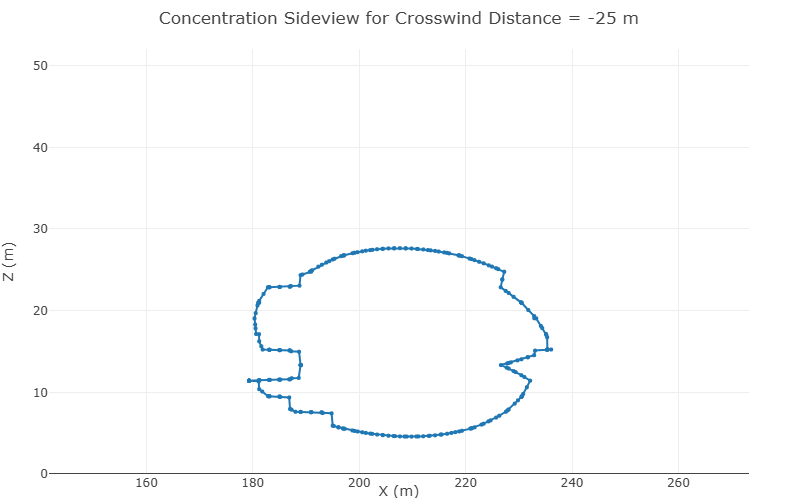

In [18]:

const frames: any[] = [];
const xBuffer = 5;
const zBuffer = 10;

for (const crosswindDistance of crosswindDistances) {
    const data = contourData[crosswindDistance];
    if (data && data.x.length > 0) {
        frames.push({
            name: `crosswind_${crosswindDistance}`,
            data: [{
                type: "scatter",
                mode: "lines+markers",
                x: data.x,
                y: data.z,
                name: `Crosswind Distance = ${crosswindDistance} m`,
                line: { width: 2 },
                marker: { size: 4 }
            }],
            layout: {
                title: `Concentration Sideview for Crosswind Distance = ${crosswindDistance} m`,
                xaxis: {
                    title: "X (m)",
                    range: [minXValue - xBuffer, maxXValue + xBuffer]
                },
                yaxis: {
                    title: "Z (m)",
                    range: [0, maxZValue + zBuffer]
                }
            }
        });
    }
}

// Create initial plot with the first frame
if (frames.length > 0) {
    const initialFrame = frames[0];
    
    Plotly.newPlot(tslab, initialFrame.data, {
        ...initialFrame.layout,
        width: 800,
        height: 500,
        showlegend: false,
        grid: true
    });
}


### Display all crosswind distances in a single plot
Let's also create a static plot showing all crosswind distances together for comparison...

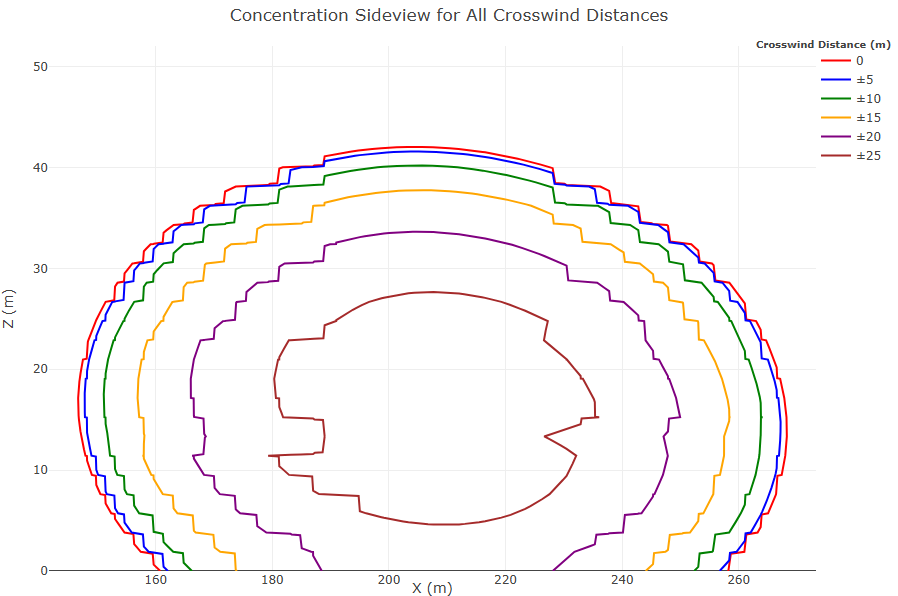

In [20]:
const allTraces: any[] = [];
const colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta'];

// Unique sorted absolute distances
const uniqueAbsDistances = Array.from(
  new Set(crosswindDistances.map(d => Math.abs(d)))
).sort((a, b) => a - b);

for (let i = 0; i < uniqueAbsDistances.length; i++) {
    const absDist = uniqueAbsDistances[i];
    const data = contourData[absDist] || contourData[-absDist];
    
    if (data && data.x.length > 0) {
        allTraces.push({
            type: "scatter",
            mode: "lines",
            x: data.x,
            y: data.z,
            name: absDist === 0 
                ? `0` 
                : `±${absDist}`,  // Just the number with ± sign
            line: {
                width: 2,
                color: colors[i % colors.length]
            }
        });
    }
}

if (allTraces.length > 0) {
    Plotly.newPlot(tslab, allTraces, {
        title: "Concentration Sideview for All Crosswind Distances",
        xaxis: {
            title: "X (m)",
            range: [minXValue - xBuffer, maxXValue + xBuffer]
        },
        yaxis: {
            title: "Z (m)",
            range: [0, maxZValue + zBuffer]
        },
        width: 900,
        height: 600,
        showlegend: true,
        legend: {
            traceorder: 'normal',
            font: {
                size: 12
            },
            // You can adjust legend positioning here
            x: 1,
            y: 1
        },
        annotations: [
            {
                xref: 'paper',
                yref: 'paper',
                x: 1.10,      // Position to right of legend
                y: 1.02,
                showarrow: false,
                text: '<b>Crosswind Distance (m)</b>',
                font: {
                    size: 10
                }
            }
        ]
    });
}
